# Importing needed libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, InputLayer, Input, Flatten, Lambda, Reshape, Activation, LayerNormalization, BatchNormalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import random
import seaborn as sns
import torch

# Collab drive mount (Optional)

In [2]:
# I have trained this model on colab with A100 GPU
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [3]:
df=pd.read_csv("/content/drive/MyDrive/2025.04.08-2025.07.03.csv")
df['time'] = pd.to_datetime(df['time'])

In [4]:
df.info()

Index(['time', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation_probability', 'precipitation',
       'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low',
       'cloud_cover_mid', 'cloud_cover_high', 'weather_code', 'wind_speed_10m',
       'wind_direction_10m', 'wind_gusts_10m', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
       'global_tilted_irradiance', 'terrestrial_radiation', 'hours',
       'day_of_week', 'month', 'day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'hours_sin', 'hours_cos', 'day_of_month_sin',
       'day_of_month_cos', 'pm10', 'pm2_5', 'carbon_monoxide',
       'carbon_dioxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone',
       'aerosol_optical_depth', 'dust', 'uv_index', 'uv_index_clear_sky',
       'methane', 'risk'],
      dtype='object')

In [5]:
from sklearn.preprocessing import StandardScaler
scale_cols=['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
      'apparent_temperature', 'precipitation_probability', 'precipitation',
      'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low',
      'cloud_cover_mid', 'cloud_cover_high', 'weather_code', 'wind_speed_10m',
      'wind_direction_10m', 'wind_gusts_10m', 'shortwave_radiation',
      'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
      'global_tilted_irradiance', 'terrestrial_radiation','pm10', 'pm2_5',
      'carbon_monoxide','carbon_dioxide', 'nitrogen_dioxide', 'sulphur_dioxide',
      'ozone','aerosol_optical_depth', 'dust', 'uv_index', 'uv_index_clear_sky',
      'methane']
df[scale_cols]=StandardScaler().fit_transform(df[scale_cols])

# Plotting data

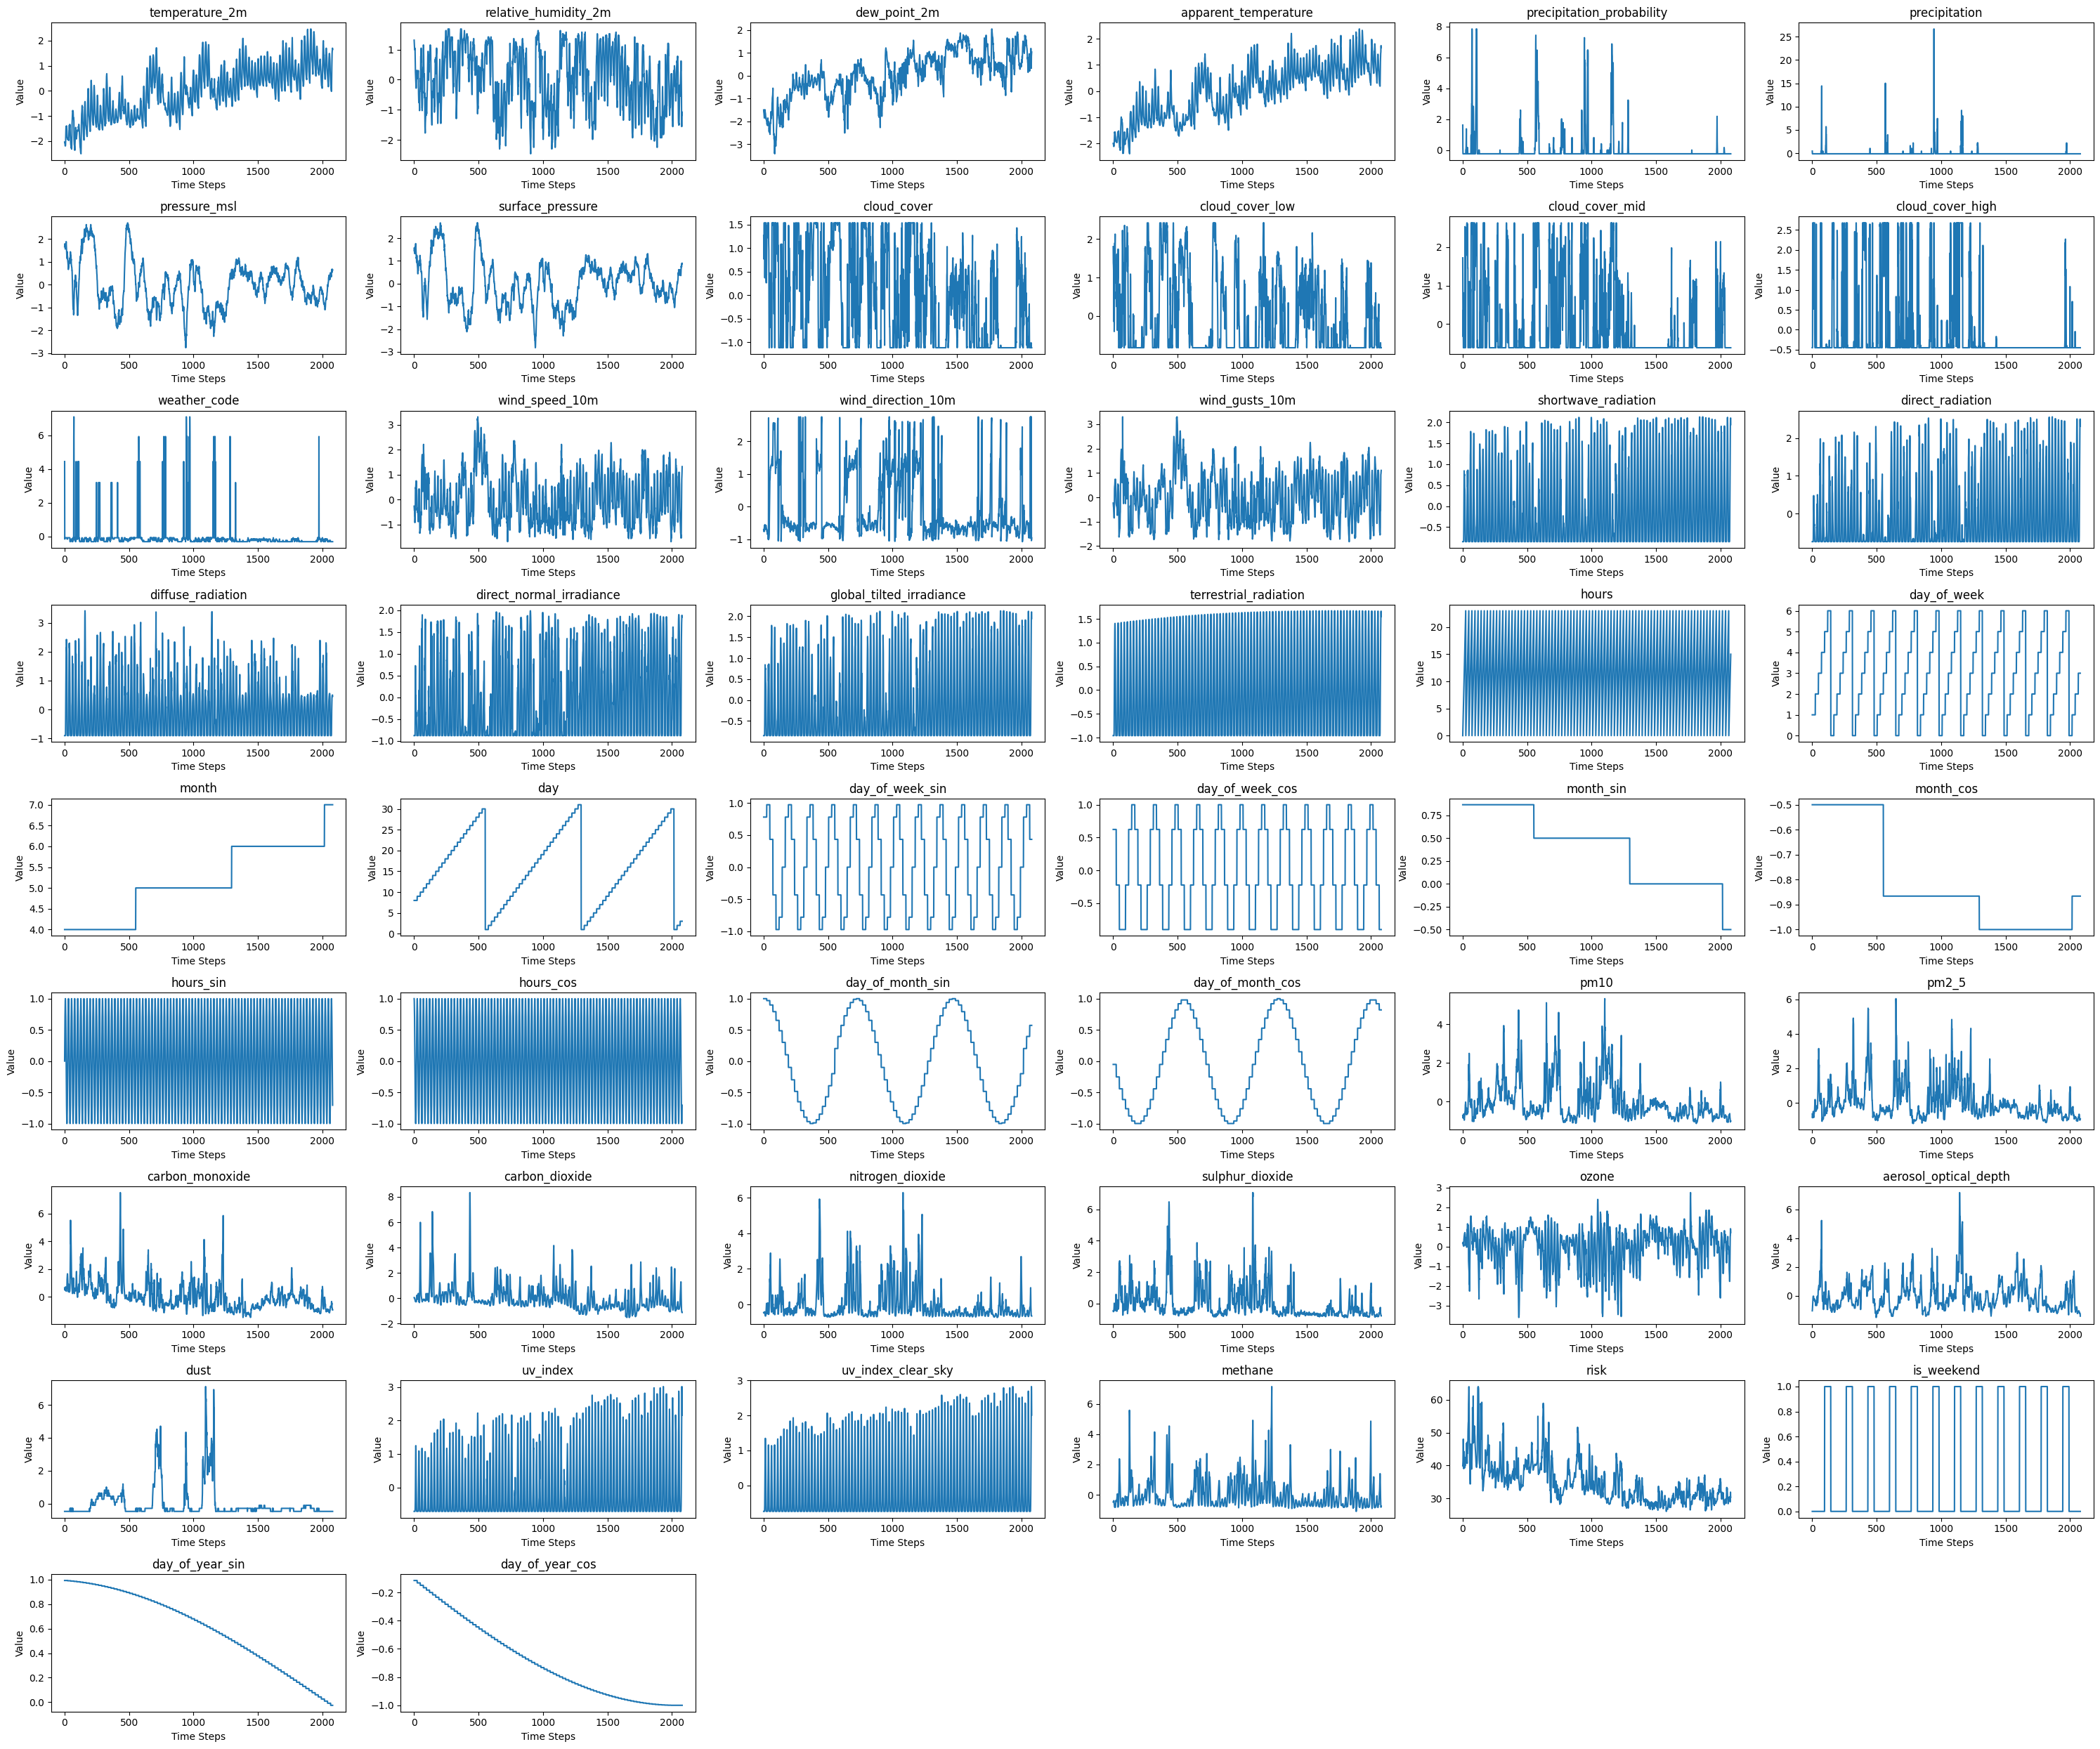

In [315]:
# Plotting all data
cols = df.select_dtypes(include=['float',"int"]).columns
plt.figure(figsize=(30, 25))

for i in range(len(cols)):
    plt.subplot(9, 6, i+1)
    plt.plot(df[cols[i]])
    plt.title(cols[i])
    plt.xlabel('Time Steps')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

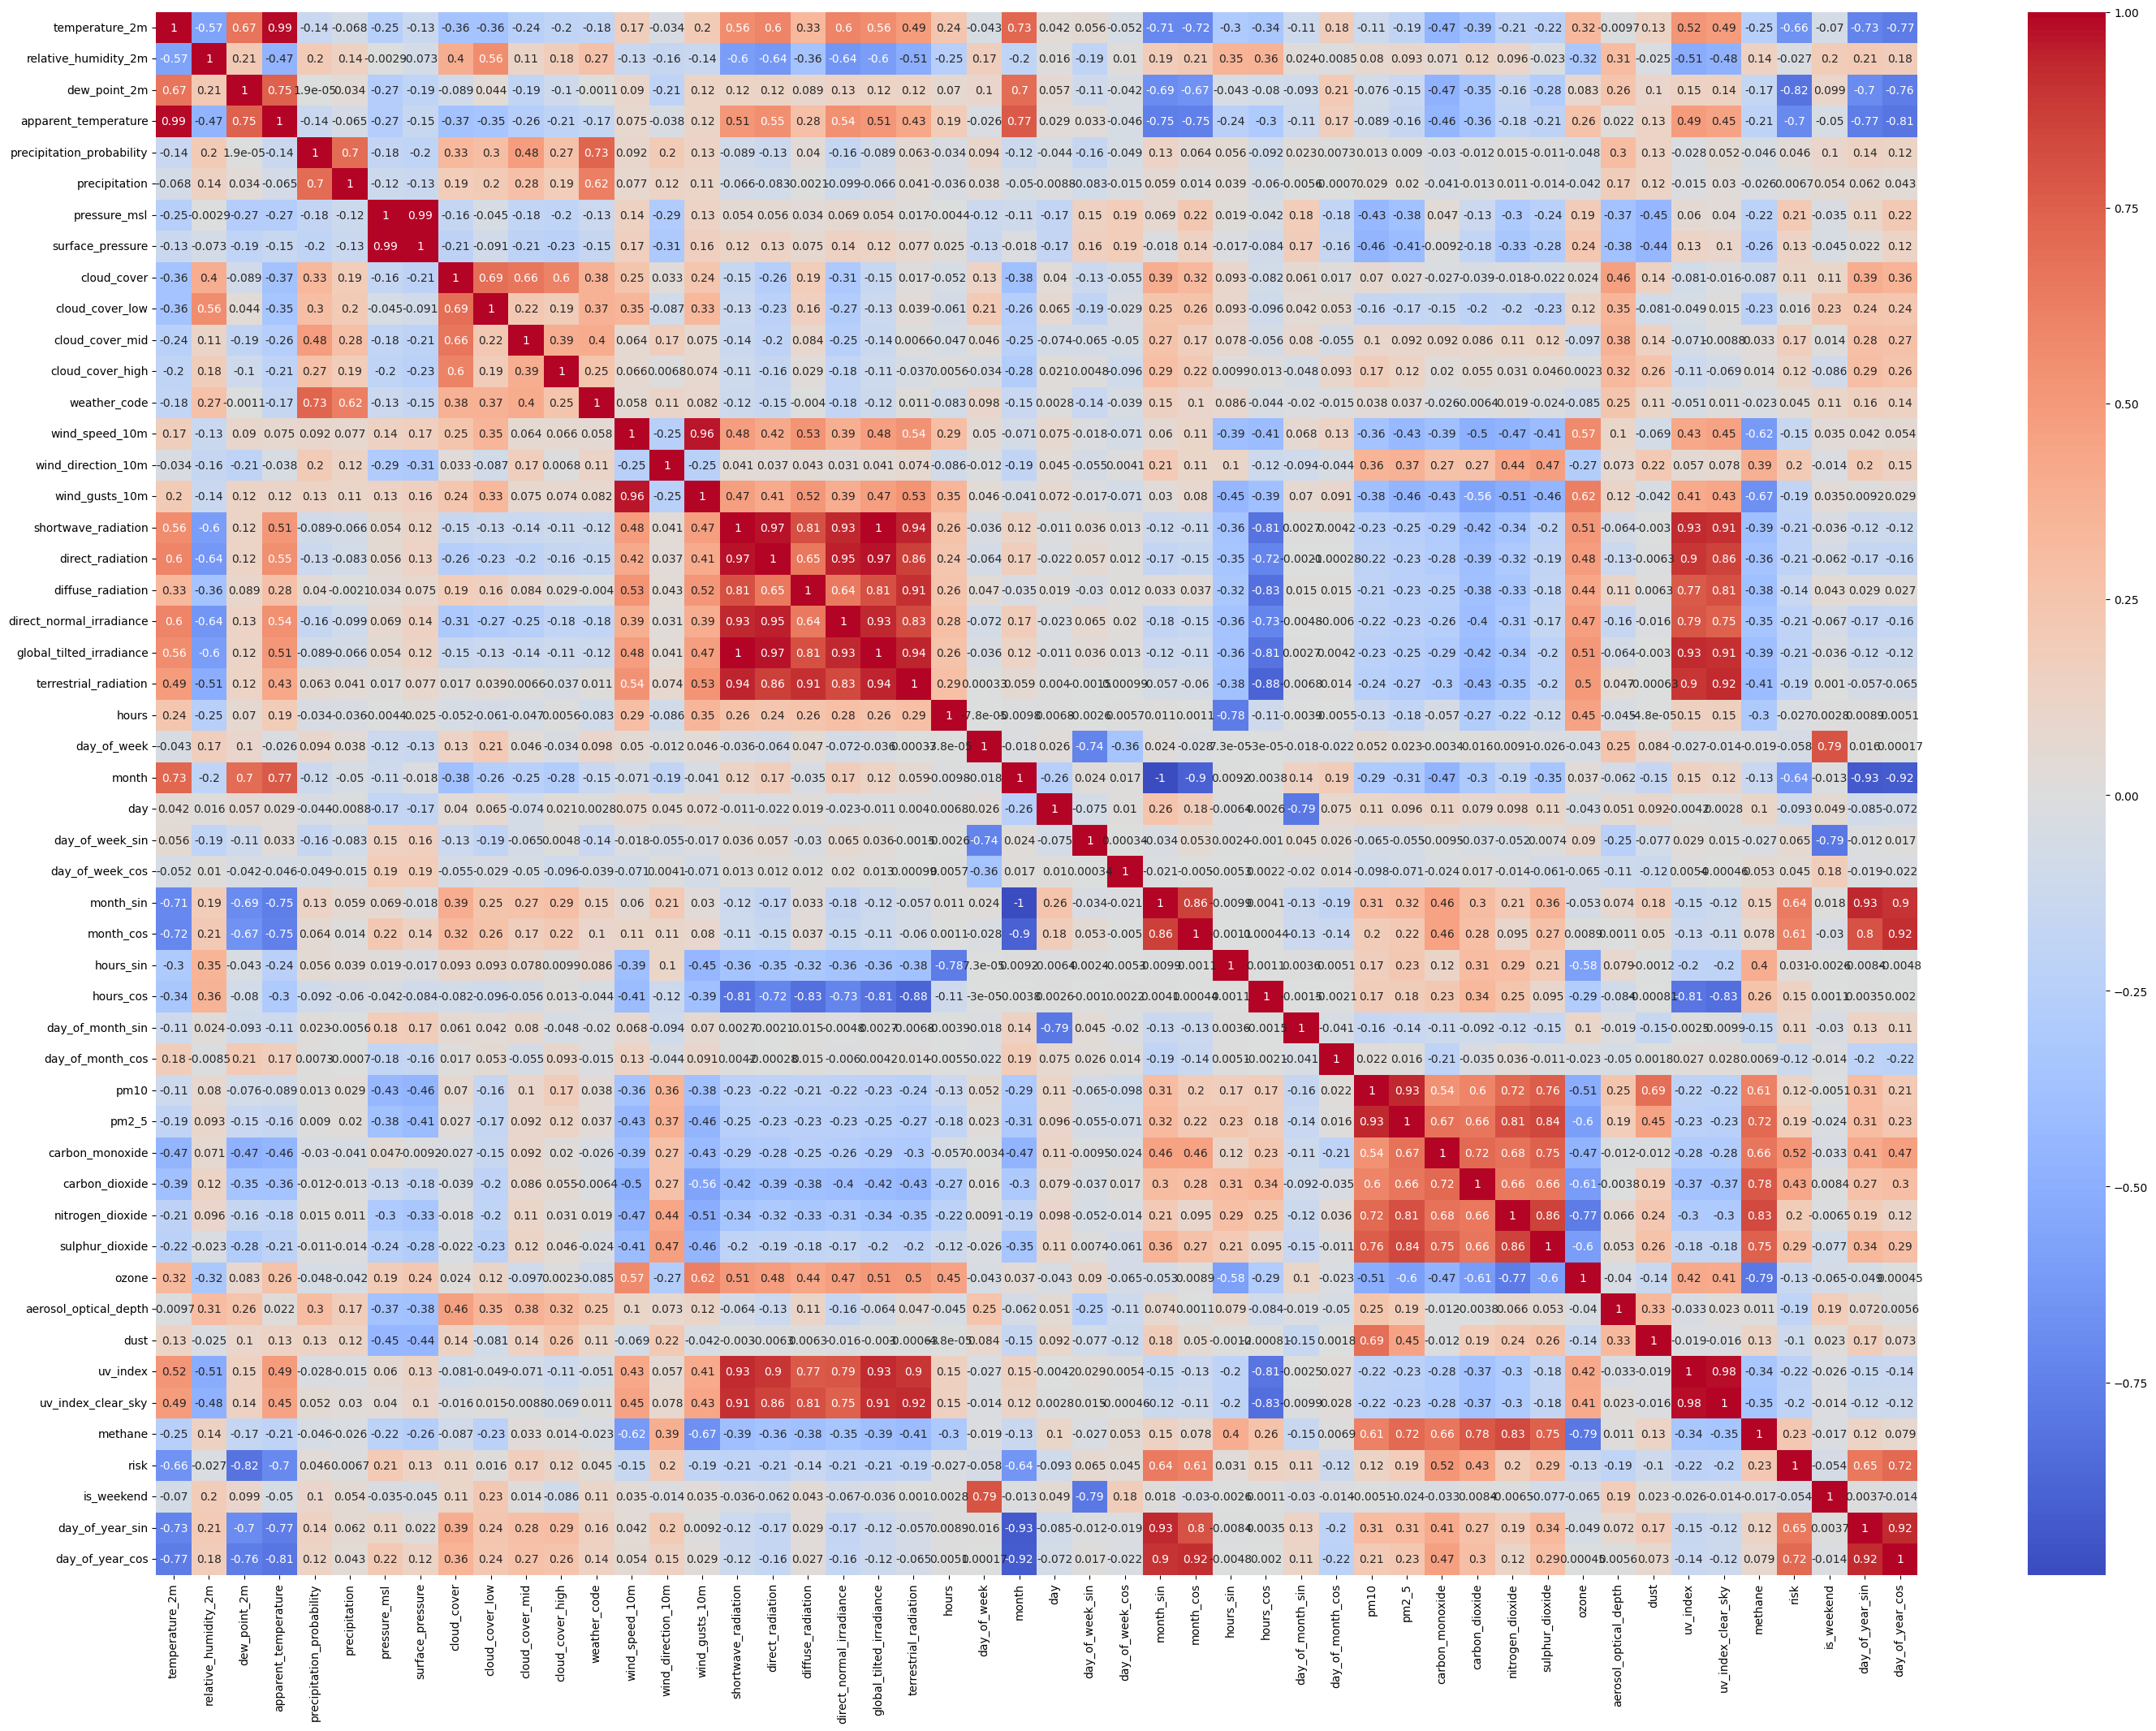

In [316]:
plt.figure(figsize=(35, 25))
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm')
plt.show()

# Decomposition analysis

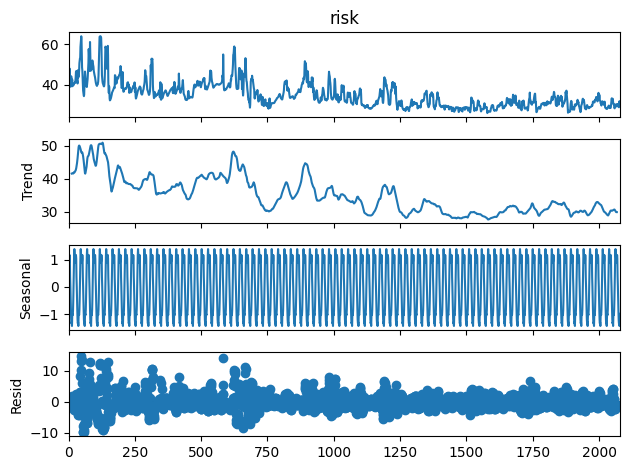

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

df['time'] = pd.to_datetime(df['time'])
series = df['risk']

decomposition = seasonal_decompose(series, model='additive', period=24)
decomposition.plot()
plt.show()

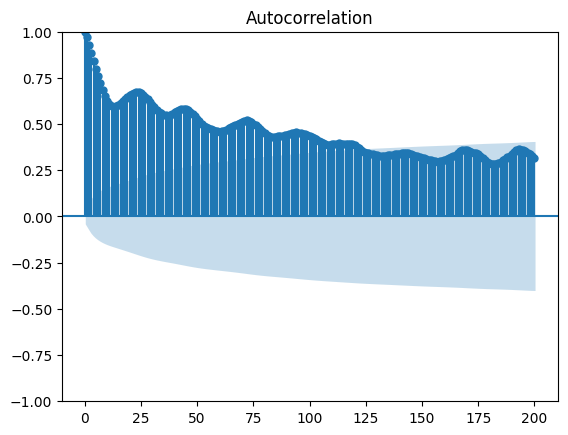

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=200)
plt.show()

# Risk Proxy

In [241]:
feature_cols = [
            'hours_sin', 'hours_cos',
            "day_of_week_sin","day_of_week_cos",
            'day_of_month_sin', 'day_of_month_cos',
            'month_sin', 'month_cos',
            'temperature_2m', "relative_humidity_2m",
            "dew_point_2m",'pressure_msl', 'wind_speed_10m',
            "pm10", "carbon_monoxide",
            "nitrogen_dioxide", "carbon_dioxide"
            ]

In [304]:
from sklearn.model_selection import train_test_split

y=df['risk'].to_numpy().reshape(-1,1)
X=df[feature_cols].to_numpy()

x_train=X[-400:]
y_train=y[-400:]

x_test=X[:-400]
y_test=y[:-400]

#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [305]:
x_train.shape

(400, 17)

In [306]:
x_test.shape

(1680, 17)

# Model architecture, training and evaluation

In [307]:
@tf.keras.utils.register_keras_serializable()
class GuaranteedFeatureModel(tf.keras.Model):
    def __init__(
        self,
        d_all,
        critical_idx,
        alpha_min=0.1,
        hidden_base=32,
        hidden_critical=16,
        l2_base=0.01,
        l2_critical=0.005,
        trainable=True,
        dtype=None,
        **kwargs
    ):
        super().__init__(trainable=trainable, dtype=dtype, **kwargs)
        self.d_all = d_all
        self.critical_idx = critical_idx if isinstance(critical_idx, list) else list(critical_idx)
        self.alpha_min = alpha_min
        self.hidden_base = hidden_base
        self.hidden_critical = hidden_critical
        self.l2_base = l2_base
        self.l2_critical = l2_critical

        # Index tensor
        self.critical_idx_tensor = tf.constant(self.critical_idx, dtype=tf.int32)

        # Networks
        self.base_net = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_base, activation='softplus',
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_base)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(hidden_base // 2, activation='softplus',
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_base)),
            tf.keras.layers.Dense(1)
        ])
        self.critical_net = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_critical, activation='softplus',
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_critical)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1)
        ])

        # Alpha parameter (learnable)
        self.s = self.add_weight(name='alpha_logit', shape=(), initializer='zeros', trainable=True)

    @property
    def alpha(self):
        # alpha in [alpha_min, 1]
        return self.alpha_min + (1.0 - self.alpha_min) * tf.sigmoid(self.s)

    def call(self, x, training=False):
        x_critical = tf.gather(x, self.critical_idx_tensor, axis=1)

        # Two branches
        base_out = self.base_net(x, training=training)
        critical_out = self.critical_net(x_critical, training=training)

        # Merge and positive output
        total_out = base_out + self.alpha * critical_out
        return tf.nn.softplus(total_out)

    def get_config(self):
        config = super().get_config()
        config.update({
            'd_all': self.d_all,
            'critical_idx': self.critical_idx,
            'alpha_min': self.alpha_min,
            'hidden_base': self.hidden_base,
            'hidden_critical': self.hidden_critical,
            'l2_base': self.l2_base,
            'l2_critical': self.l2_critical,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


d_all = X.shape[1]
critical_features = [0, 1, 2, 3, 4, 5]
model = GuaranteedFeatureModel(
d_all=d_all,
critical_idx=critical_features,
alpha_min=0.4,
l2_base=0.01,
l2_critical=0.005
)

In [308]:
print("Alpha:", model.alpha)

Alpha: tf.Tensor(0.70000005, shape=(), dtype=float32)


In [309]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

loss_fn=tf.keras.losses.MeanSquaredError()
model.compile(loss=loss_fn,
              optimizer=optimizer, metrics=['mae'])

history=model.fit(x_train, y_train, epochs=400, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 460ms/step - loss: 875.6571 - mae: 29.5007 - val_loss: 1036.4663 - val_mae: 31.4657
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 531.8224 - mae: 22.7778 - val_loss: 626.5250 - val_mae: 23.7501
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 134.6368 - mae: 10.5112 - val_loss: 300.7123 - val_mae: 14.1798
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 74.0622 - mae: 6.6880 - val_loss: 215.9213 - val_mae: 11.7089
Epoch 5/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 49.5042 - mae: 5.6415 - val_loss: 240.2522 - val_mae: 13.4528
Epoch 6/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 38.2195 - mae: 4.8821 - val_loss: 224.1820 - val_mae: 13.0302
Epoch 7/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 29.2098 - mae: 4.2481 - val_loss: 174.6172 - val_mae: 10.8743
Epoch 8/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 22.6409 - mae: 3.7535 - val_loss: 166.7599 - val_mae: 10.4835
Epoch 9/400
7/7 ━━━━━━━━━━━━━━━━

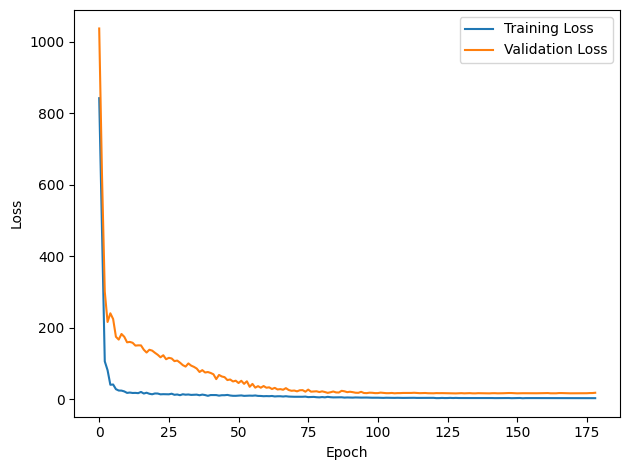

In [310]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [311]:
model.evaluate(x_test, y_test)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.6174 - mae: 3.5813


[16.283447265625, 2.839731216430664]

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


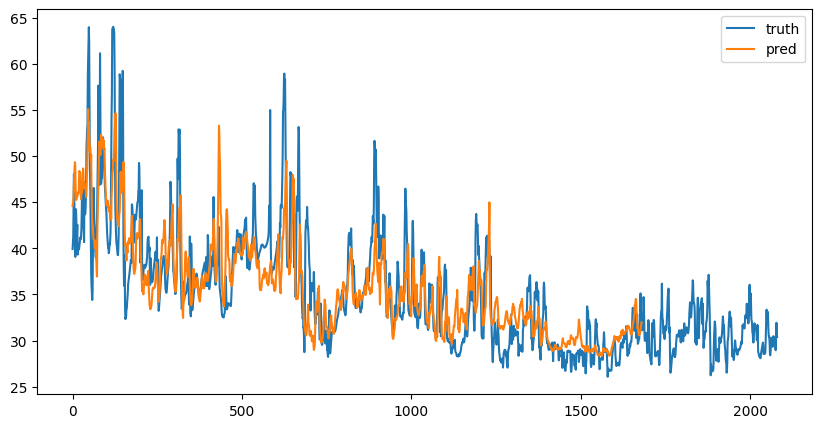

In [312]:
y_p=model.predict(x_test)

plt.figure(figsize=(10, 5))
plt.plot(y, label="truth")
plt.plot(y_p, label="pred")
plt.legend()
plt.show()

In [313]:
print("Alpha:", model.alpha)

Alpha: tf.Tensor(0.7619395, shape=(), dtype=float32)


PermutationExplainer explainer: 1681it [03:38,  7.33it/s]
/tmp/ipython-input-1499192927.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test, feature_names=feature_cols)


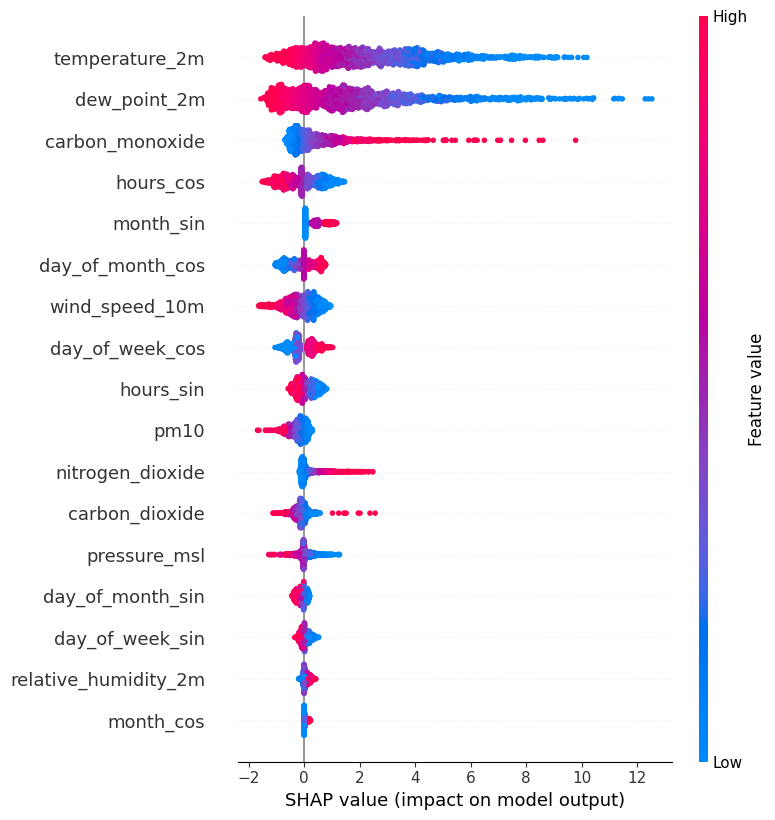

temperature_2m: 2.4611
dew_point_2m: 2.1855
carbon_monoxide: 0.7268
hours_cos: 0.6100
month_sin: 0.4944
day_of_month_cos: 0.4930
wind_speed_10m: 0.4046
day_of_week_cos: 0.3747
hours_sin: 0.2739
pm10: 0.2624
nitrogen_dioxide: 0.2212
carbon_dioxide: 0.2071
pressure_msl: 0.2030
day_of_month_sin: 0.1519
day_of_week_sin: 0.1298
relative_humidity_2m: 0.0928
month_cos: 0.0643


In [314]:
import shap

explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_test)

shap.summary_plot(shap_values, x_test, feature_names=feature_cols)
# Feature importance için:
shap_importance = np.abs(shap_values.values).mean(axis=0)
for i in shap_importance.argsort()[::-1]:
    print(f"{feature_cols[i]}: {shap_importance[i]:.4f}")

# The end...